# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

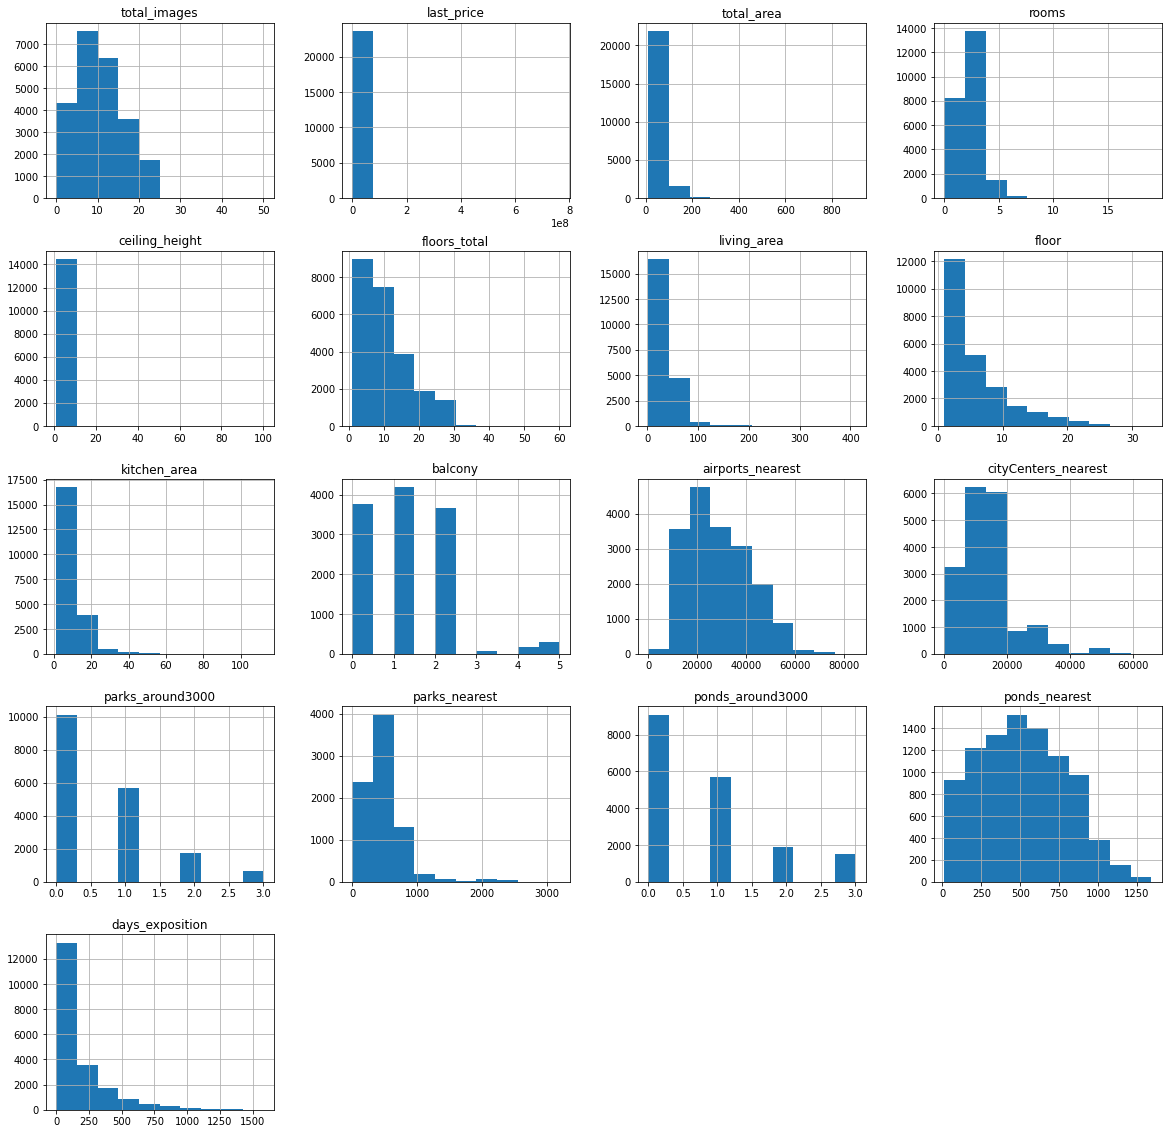

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

data.head(10)

data.info()

data.hist(figsize=(20,20))


### Предобработка данных

In [3]:
data.isna().sum() #находим количество пропущенных значений в столбцах 
#пропущенные значения есть в 13 столбцах 

data['balcony']=data['balcony'].fillna(0) #пропущенные значения балковнов вероятно обусловены отсутсвием балконов, 
#поэтому их количество можно принять за 0

data['parks_around3000']=data['parks_around3000'].fillna(0) #аналогично логике отсутсвия значений количества балконов принимаем 0 для пропущенных значений
data['ponds_around3000']=data['ponds_around3000'].fillna(0) #аналогично логике отсутсвия значений количества балконов принимаем 0 для пропущенных значений
data['days_exposition'] = data['days_exposition'].fillna(0) #объявление только появилось
data.isna().sum()


data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


data['floor'] = data['floor'].astype('int') #количество этажей может быть только четным
data['is_apartment'] = data['is_apartment'].astype('bool') #булево значение
data['balcony'] = data['balcony'].astype('int') #количество балконов может быть только четным
data['parks_around3000'] = data['parks_around3000'].astype('int') #количество парков может быть только четным
data['ponds_around3000'] = data['ponds_around3000'].astype('int') #количество водоемов может быть только четным
data['days_exposition'] = data['days_exposition'].astype('int') #количество дней может быть только четным



data['locality_name'].unique()

data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')


data.isna().sum()
data.loc[(data['ceiling_height']>20) & (data['ceiling_height']<40), 'ceiling_height'] = data['ceiling_height']/10
data.loc[(data['ceiling_height']>4) & (data['ceiling_height']<7), 'ceiling_height'] = data['ceiling_height']/2
#приводим анамально большие значения к реальным значениям

data['ceiling_height'].sort_values(ascending = True)
data = data[(data['ceiling_height'] !=100) & (data['ceiling_height'] !=1) & (data['ceiling_height'] !=1.2) & (data['ceiling_height'] !=1.75)]
#убираем оставшиееся слишком большие и слишком маленькие значения

data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23695 non-null  int64         
 1   last_price            23695 non-null  float64       
 2   total_area            23695 non-null  float64       
 3   first_day_exposition  23695 non-null  datetime64[ns]
 4   rooms                 23695 non-null  int64         
 5   ceiling_height        14500 non-null  float64       
 6   floors_total          23609 non-null  float64       
 7   living_area           21792 non-null  float64       
 8   floor                 23695 non-null  int64         
 9   is_apartment          23695 non-null  bool          
 10  studio                23695 non-null  bool          
 11  open_plan             23695 non-null  bool          
 12  kitchen_area          21417 non-null  float64       
 13  balcony         

In [4]:
data['floors_total'].sort_values()
data['floors_total'] = data['floors_total'].fillna(0)
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].dropna()
data['floors_total'] = data.loc[(data['floors_total']<=30) & (data['floors_total']>=1), 'floors_total']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23695 non-null  int64         
 1   last_price            23695 non-null  float64       
 2   total_area            23695 non-null  float64       
 3   first_day_exposition  23695 non-null  datetime64[ns]
 4   rooms                 23695 non-null  int64         
 5   ceiling_height        14500 non-null  float64       
 6   floors_total          23578 non-null  float64       
 7   living_area           21792 non-null  float64       
 8   floor                 23695 non-null  int64         
 9   is_apartment          23695 non-null  bool          
 10  studio                23695 non-null  bool          
 11  open_plan             23695 non-null  bool          
 12  kitchen_area          21417 non-null  float64       
 13  balcony         

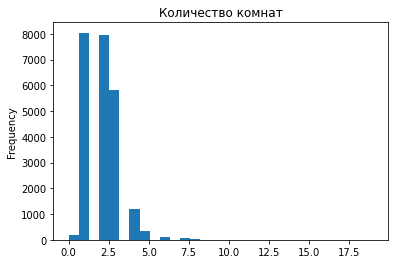

In [5]:
data['rooms'].plot(kind = 'hist', bins=30, title = 'Количество комнат')
data['rooms'] = data.loc[data['rooms']<=6, 'rooms']
data['rooms'].value_counts()
data['rooms'] = data['rooms'].fillna(0)
data['rooms'] = data['rooms'].astype('int')
data['floors_total'].dropna()
data['rooms'] = data.loc[data['rooms']!=0, 'rooms']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23695 non-null  int64         
 1   last_price            23695 non-null  float64       
 2   total_area            23462 non-null  float64       
 3   first_day_exposition  23695 non-null  datetime64[ns]
 4   rooms                 23408 non-null  float64       
 5   ceiling_height        14500 non-null  float64       
 6   floors_total          23578 non-null  float64       
 7   living_area           21792 non-null  float64       
 8   floor                 23695 non-null  int64         
 9   is_apartment          23695 non-null  bool          
 10  studio                23695 non-null  bool          
 11  open_plan             23695 non-null  bool          
 12  kitchen_area          21417 non-null  float64       
 13  balcony         

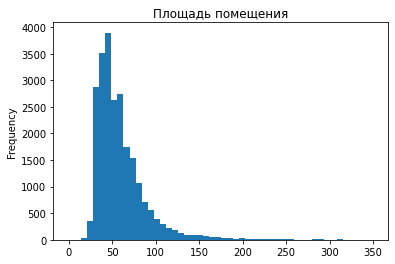

In [6]:
data['total_area'].plot(kind = 'hist', bins=50, range=(0,350), title = 'Площадь помещения')
data['total_area'] = data.loc[(data['total_area']<=200) & (data['total_area']>=15), 'total_area']
data.info()

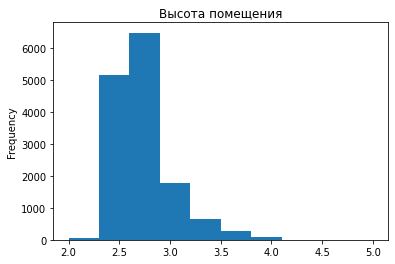

In [7]:
data['ceiling_height'].plot(kind = 'hist', bins=10, range=(2,5), title = 'Высота помещения')
data['ceiling_height'] = data.loc[data['ceiling_height']<=4, 'ceiling_height']

1580

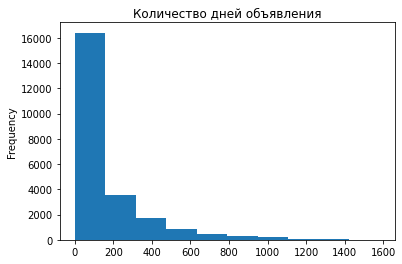

In [8]:
data['days_exposition'].plot(kind = 'hist', title = 'Количество дней объявления')
data['days_exposition'].max()

17456    430000.0
14911    430000.0
16274    440000.0
16219    450000.0
17676    450000.0
5698     450000.0
9581     450000.0
23484    470000.0
21912    470000.0
18867    470000.0
Name: last_price, dtype: float64

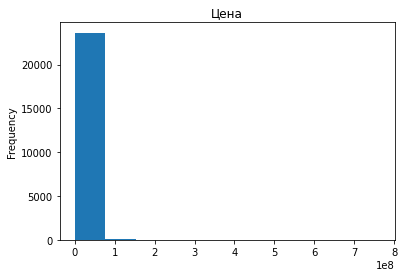

In [9]:
data['last_price'].plot(kind = 'hist', title = 'Цена')
data['last_price'] = data.loc[(data['last_price']<7.000000e+08) & (data['last_price']>100000), 'last_price']
data['last_price'].sort_values().head(10)

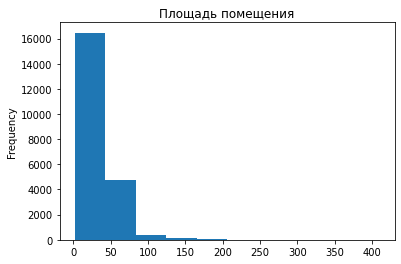

In [10]:
data['living_area'].plot(kind = 'hist', title = 'Площадь помещения')
data['living_area'] = data.loc[(data['living_area']<170) & (data['living_area']>=10), 'living_area']

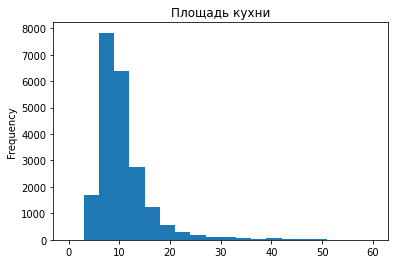

In [11]:
data['kitchen_area'].plot(kind = 'hist', bins=20, range=(0,60), title = 'Площадь кухни')
data['kitchen_area'] = data.loc[(data['kitchen_area']<45) & (data['kitchen_area']>=3), 'kitchen_area']

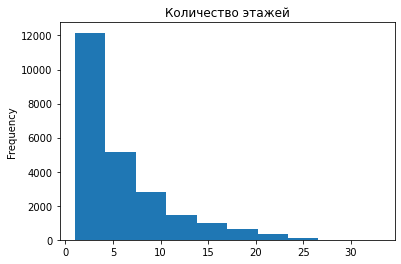

In [12]:
data['floor'].plot(kind = 'hist', title = 'Количество этажей')
data['floor'] = data.loc[data['floor']<23, 'floor']

### Посчитайте и добавьте в таблицу новые столбцы

In [13]:
data['total_area'] = data.loc[data['total_area'] != 0, 'total_area']
data['priceperm'] = data['last_price'] / data['total_area'] #создаем новый столбец с ценой за 1 кв. метр

data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

data['month_exposition'] = data['first_day_exposition'].dt.month

data['year_exposition'] = data['first_day_exposition'].dt.year
#по одному и тому же принципу создаем столбцы для значений дня недели, месяца и года

def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
#создадим функцию, определяющую этаж 
data['floor_type'] = data.apply(floor_type, axis = 1) #создадим новый столбец с помощью собственной функции


data['city_centers_nearest_km']=data['city_centers_nearest'] / 1000
data['city_centers_nearest_km']=data['city_centers_nearest_km'].round()
data.info()
#переводим значения в км и округляем до целого числа 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23695 non-null  int64         
 1   last_price               23693 non-null  float64       
 2   total_area               23462 non-null  float64       
 3   first_day_exposition     23695 non-null  datetime64[ns]
 4   rooms                    23408 non-null  float64       
 5   ceiling_height           14493 non-null  float64       
 6   floors_total             23578 non-null  float64       
 7   living_area              21696 non-null  float64       
 8   floor                    23446 non-null  float64       
 9   is_apartment             23695 non-null  bool          
 10  studio                   23695 non-null  bool          
 11  open_plan                23695 non-null  bool          
 12  kitchen_area             21319 n

### Проведите исследовательский анализ данных

<AxesSubplot:title={'center':'Площадь помещения'}, ylabel='Frequency'>

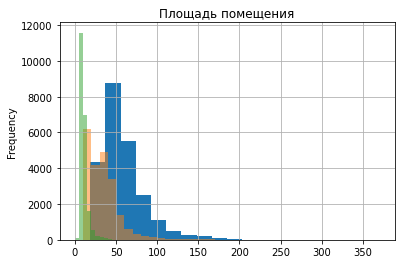

In [14]:
data['total_area'].plot(kind = 'hist', bins=20, range=(0,370), title = 'Площадь помещения')
#40-60 кв.м. - недвижимости с такой площадью больше всего на сайте объявлений 

data['living_area'].plot(kind = 'hist', bins=20, alpha=0.5, range=(0,200))
#приблизительно 20 кв.м - самая популярная площадь жилой зоны
data['kitchen_area'].hist(bins=20, alpha=0.5, range=(0,100))
#приблизительно 5-10 кв.м - самая популярная площадь кухни

0        13000000.0
1         3350000.0
2         5196000.0
3        64900000.0
4        10000000.0
            ...    
23694     9700000.0
23695     3100000.0
23696     2500000.0
23697    11475000.0
23698     1350000.0
Name: last_price, Length: 23695, dtype: float64

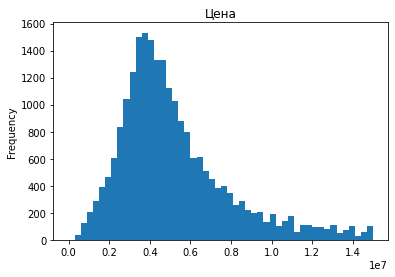

In [15]:
data['last_price'].plot(kind = 'hist', bins=50, range=(0,15000000), title = 'Цена')
data['last_price'].mean()
data['last_price']

Цены на недвижимость весьма разнообразны, но это распределение нормальное. Больше всего недвижимости в диапазоне 0,35 - 0,4

<AxesSubplot:title={'center':'Количество комнат'}, ylabel='Frequency'>

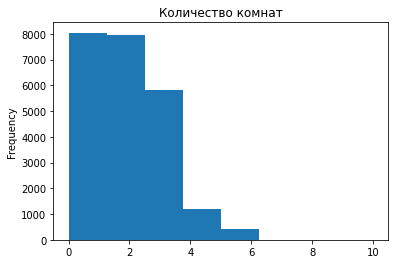

In [16]:
data['rooms'].plot(kind = 'hist', bins=8, range=(0,10), title = 'Количество комнат')

Чаще всего встречается 1-комнатная и 2-комнатная недвижимость

<AxesSubplot:title={'center':'Высота'}, ylabel='Frequency'>

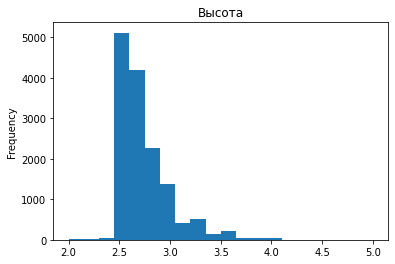

In [17]:
data['ceiling_height'].plot(kind = 'hist', bins=20, range=(2,5), title = 'Высота')

В среднем высота потолков приблизительно равна 2,5 м

<AxesSubplot:title={'center':'Этажи'}, ylabel='Frequency'>

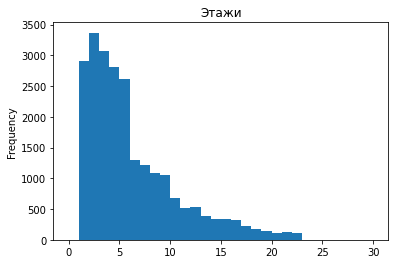

In [18]:
data['floor'].plot(kind = 'hist', bins=30, range=(0,30), title = 'Этажи')

Превышвет количство недвижимости, находящейся на 1-6 этажах

<AxesSubplot:>

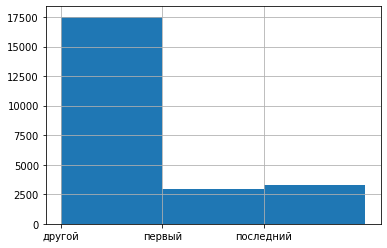

In [19]:
data['floor_type'].hist(bins=3, range=(0,3))

Очевидно, что не первый и не последний этаж встречается гораздо чаще, чем первый и последний этажи

<AxesSubplot:title={'center':'Всего этажей'}, ylabel='Frequency'>

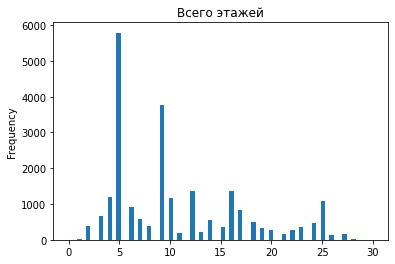

In [20]:
data['floors_total'].plot(kind = 'hist', bins=70, range=(0,30), title = 'Всего этажей')

Больше всего на сайте объявлений представлено недвижимости, ноходящейся в 5-этажных зданиях, на 2-ом месте 9-этажные здания

<AxesSubplot:title={'center':'Расстояние от центра'}, ylabel='Frequency'>

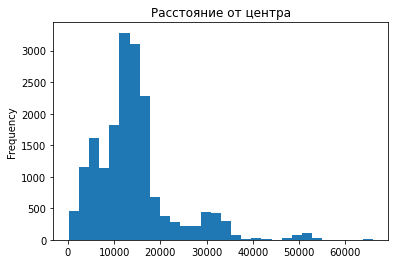

In [21]:
data['city_centers_nearest'].plot(kind = 'hist', bins=30, title = 'Расстояние от центра')

Большинство недвижимости находится на расстоянии 10000-15000 м от центра

<AxesSubplot:title={'center':'Расстояние от аэропорта'}, ylabel='Frequency'>

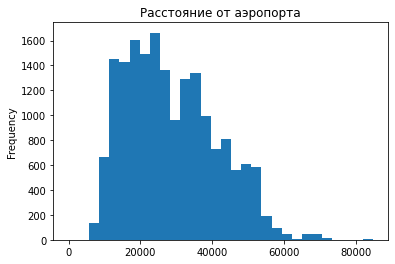

In [22]:
data['airports_nearest'].plot(kind = 'hist', bins=30, title = 'Расстояние от аэропорта')

Самое часто встречающееся расстояние до аэропорта приблизительно равно 11000-18000 м

<AxesSubplot:title={'center':'Расстояние до парков'}, ylabel='Frequency'>

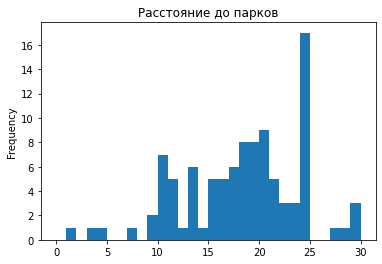

In [23]:
data['parks_nearest'].plot(kind = 'hist', bins=30, range=(0,30), title = 'Расстояние до парков')

25 м - самое часто встречающееся расстояние до парков

<AxesSubplot:>

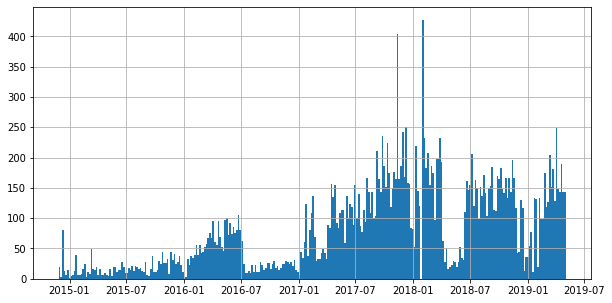

In [24]:
data['first_day_exposition'].hist(bins=300, figsize = (10,5))

Чаще всего объявления появлялись в 2018 году

<AxesSubplot:title={'center':'День поялвения объявления'}, ylabel='Frequency'>

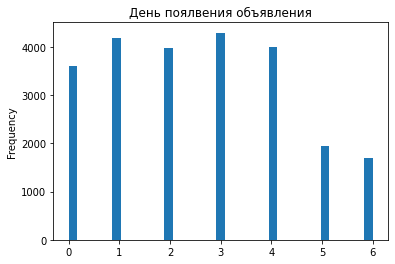

In [25]:
data['weekday_exposition'].plot(kind = 'hist', bins=35, range=(0,6), title = 'День поялвения объявления')

В выходные добавляют существенно меньше объявлений, чем в будние дни, чаще объявления добавляют с понедельника по пятницу

<AxesSubplot:title={'center':'Месяц появления объявлений'}, ylabel='Frequency'>

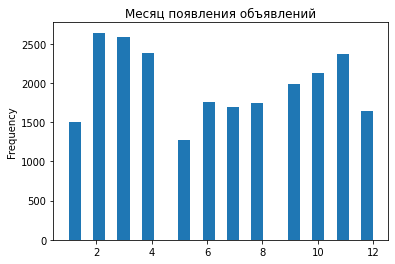

In [26]:
data['month_exposition'].plot(kind = 'hist', bins=25, range=(1,12), title = 'Месяц появления объявлений')

Объявления добавляются ежемесячно, но чаще в холодное время года

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23695 non-null  int64         
 1   last_price               23693 non-null  float64       
 2   total_area               23462 non-null  float64       
 3   first_day_exposition     23695 non-null  datetime64[ns]
 4   rooms                    23408 non-null  float64       
 5   ceiling_height           14493 non-null  float64       
 6   floors_total             23578 non-null  float64       
 7   living_area              21696 non-null  float64       
 8   floor                    23446 non-null  float64       
 9   is_apartment             23695 non-null  bool          
 10  studio                   23695 non-null  bool          
 11  open_plan                23695 non-null  bool          
 12  kitchen_area             21319 n

<AxesSubplot:title={'center':'Свежесть объявления'}, ylabel='Frequency'>

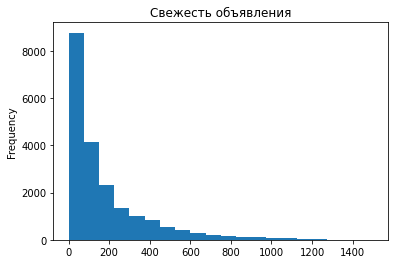

In [28]:
data['days_exposition'] = data.loc[(data['days_exposition']!=0) & (data['days_exposition']<1250), 'days_exposition']
data['days_exposition'].plot(kind = 'hist', bins=20, range=(0,1500), title = 'Свежесть объявления')

По гистограмме видно, что крайне большое количество объявлений были выставлены совсем недавно

In [29]:
data['days_exposition'].median()

95.0

In [30]:
data['days_exposition'].mean()

176.9629756431576

Медиана и среднее арифметическое различаются практически в 2 раза

In [31]:
days_exposition_pivot = data.pivot_table(index = 'year_exposition', values='days_exposition', aggfunc=['median', 'mean'])
days_exposition_pivot.columns = ['median', 'mean']
days_exposition_pivot

,median,mean
year_exposition,,
2014,772.5,825.284314
2015,558.0,614.709346
2016,235.0,320.748159
2017,103.0,158.955791
2018,64.0,94.358693
2019,23.0,30.931671


С каждым годом среднее время нахождения объявления на сайте уменьшалось

0.6594789519815255

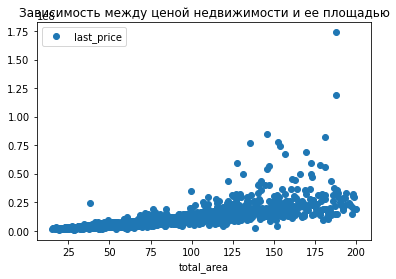

In [32]:
data_pivot_total_area = data.pivot_table(index='total_area', values='last_price', aggfunc='median')
data_pivot_total_area

data_pivot_total_area.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и ее площадью')
data['last_price'].corr(data['total_area'])

Коэффициент корреляции и график показывают, что между ценой недвижимости и ее площадью есть небольшая зависимость 

0.5770807698765136

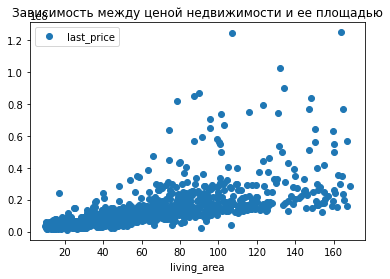

In [33]:
data_pivot_living_area = data.pivot_table(index='living_area', values='last_price', aggfunc='median')
data_pivot_living_area

data_pivot_living_area.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и ее площадью')
data['last_price'].corr(data['living_area'])

Коэффициент корреляции и график показывают, что между ценой недвижимости и ее площадью сильной зависимости нет, при этом она еще меньше чем корреляция между общей площадью и ценой

0.45979018381656916

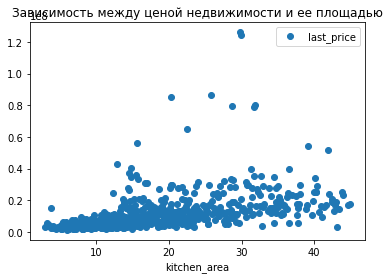

In [34]:
data_pivot_kitchen_area = data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
data_pivot_kitchen_area

data_pivot_kitchen_area.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и ее площадью')
data['last_price'].corr(data['kitchen_area'])

коэффициент корреляции и график показывают, что между ценой недвижимости и ее площадью сильной зависимости нет, при этом она еще меньше, чем корреляция между площадью жилого опмещения и ценой

0.36853588691237715

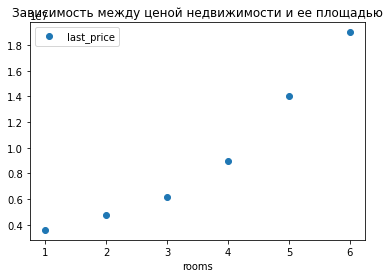

In [35]:
data_pivot_rooms = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
data_pivot_rooms

data_pivot_rooms.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и ее площадью')
data['last_price'].corr(data['rooms'])

Коэффициент корреляции показывает, что зависимость крайне слабая, хотя график показывает обратное 

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и ее площадью'}, xlabel='floor_type'>

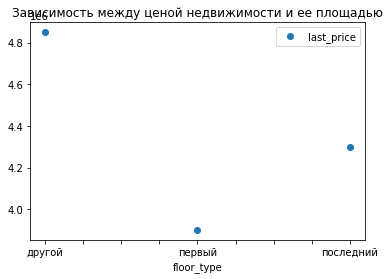

In [36]:
data_pivot_floor_type = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
data_pivot_floor_type

data_pivot_floor_type.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и ее площадью')

Коэффициент корреляции невозможно отобразить, при этом на графике видно, что первый этаж стоит дешевле всех, последний этаж находится на 2-ом месте по цене, другие этажи имеют самую большую цену

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и датой'}, xlabel='first_day_exposition'>

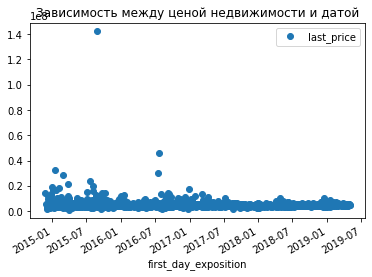

In [37]:
data_pivot_first_day_exposition = data.pivot_table(index='first_day_exposition', values='last_price', aggfunc='median')
data_pivot_first_day_exposition

data_pivot_first_day_exposition.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и датой')

Коэффициент корреляции невозможно отобразить, при этом график демонстрирует отсутсвие зависимости по данным параметрам

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23695 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23695 non-null  int64         
 1   last_price               23693 non-null  float64       
 2   total_area               23462 non-null  float64       
 3   first_day_exposition     23695 non-null  datetime64[ns]
 4   rooms                    23408 non-null  float64       
 5   ceiling_height           14493 non-null  float64       
 6   floors_total             23578 non-null  float64       
 7   living_area              21696 non-null  float64       
 8   floor                    23446 non-null  float64       
 9   is_apartment             23695 non-null  bool          
 10  studio                   23695 non-null  bool          
 11  open_plan                23695 non-null  bool          
 12  kitchen_area             21319 n

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и месяцем'}, xlabel='month_exposition'>

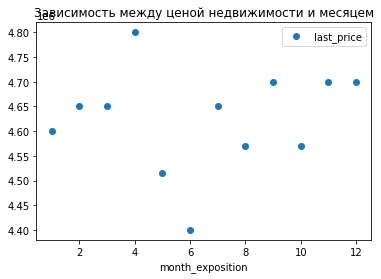

In [39]:
data_pivot_month_exposition = data.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
data_pivot_month_exposition

data_pivot_month_exposition.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и месяцем')

Коэффициент корреляции невозможно отобразить, при этом график демонстрирует отсутсвие зависимости по данным параметрам

In [40]:
data_pivot_year_exposition = data.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
data_pivot_year_exposition


,last_price
year_exposition,
2014,7700000.0
2015,5350000.0
2016,4550000.0
2017,4500000.0
2018,4550000.0
2019,5050000.0


In [41]:
days_exposition_pivot

,median,mean
year_exposition,,
2014,772.5,825.284314
2015,558.0,614.709346
2016,235.0,320.748159
2017,103.0,158.955791
2018,64.0,94.358693
2019,23.0,30.931671


Время нахождения объявления на сайте уменьшается со временем

In [42]:
total_area_pivot = data.pivot_table(index='year_exposition', values='total_area', aggfunc='median')
total_area_pivot

,total_area
year_exposition,
2014,76.05
2015,60.00
2016,53.00
2017,51.60
2018,50.20
2019,51.50


Средняя площадь выставляемых квартир с годами уменьшалась

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и годом'}, xlabel='year_exposition'>

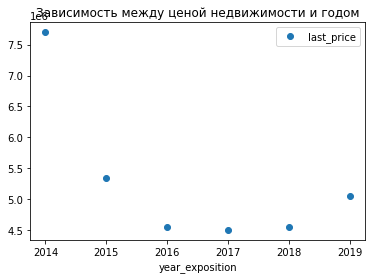

In [43]:
data_pivot_year_exposition.plot(y = 'last_price', style = 'o', title = 'Зависимость между ценой недвижимости и годом')

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и годом'}, xlabel='year_exposition'>

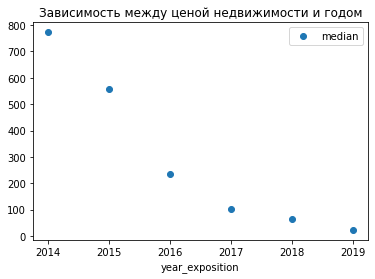

In [44]:
days_exposition_pivot.plot(y = 'median', style = 'o', title = 'Зависимость между ценой недвижимости и годом')

<AxesSubplot:title={'center':'Зависимость между ценой недвижимости и годом'}, xlabel='year_exposition'>

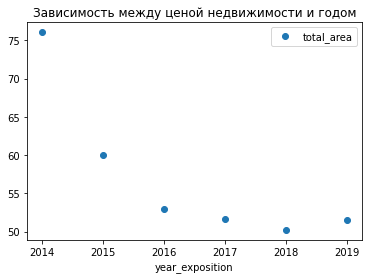

In [45]:
total_area_pivot.plot(y = 'total_area', style = 'o', title = 'Зависимость между ценой недвижимости и годом')

Все изченные параметры имеют нисходящую тенденцию, то есть уменьшаются по ходу времени

<AxesSubplot:title={'center':'Населенные пункты и количество объявлений'}, xlabel='locality_name'>

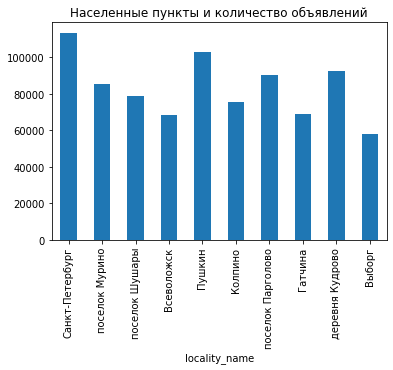

In [46]:
data_10_locality_name = data.pivot_table(index='locality_name', values='priceperm', aggfunc= ['mean', 'count'])
data_10_locality_name.columns = ['mean', 'count']
data_10_locality_name=data_10_locality_name.sort_values(by='count', ascending=False).head(10)

#выводим 10 населенных пунктов с самым большим количеством объявлений, а также среднюю цену объявлений по населенному пункту

data_10_locality_name['mean'].plot.bar(title = 'Населенные пункты и количество объявлений')

Первое место по количеству объявлений занимает Санкт-Петербург, в котором самая высокая средняя ценя за недвижимость. 10-ое место занимает Выборг, в котором самая низкая средняя цена недвижимости из всех 10-ти населенных пунктов


<AxesSubplot:title={'center':'Стоимость недвижимости в зависимости от расположения от центра'}, xlabel='city_centers_nearest_km'>

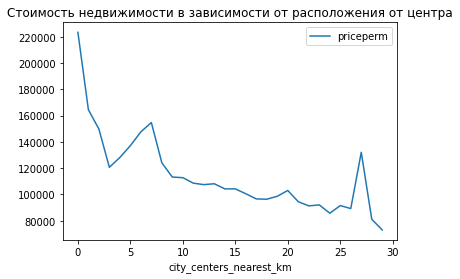

In [47]:
data_SP = data[data['locality_name']=='Санкт-Петербург'].pivot_table(
    index = 'city_centers_nearest_km', 
    values = 'priceperm', 
    aggfunc = 'mean'
)
data_SP

data_SP.plot(y = 'priceperm', title = 'Стоимость недвижимости в зависимости от расположения от центра')

График показывает, что в большинстве случаев, чем ближе недвижимость к центру, тем дороже ее стоимость

In [48]:
new_data = data[data['locality_name']=='Санкт-Петербург'].pivot_table(
    index = 'city_centers_nearest_km', 
    values = 'last_price', 
    aggfunc = ('mean', 'count')
)
new_data.columns = ['count', 'mean']
new_data['c_m'] = new_data['mean'] / new_data['count']
new_data

,count,mean,c_m
city_centers_nearest_km,,,
0.0,27,3.144912e+07,1.164782e+06
1.0,192,2.120672e+07,1.104517e+05
2.0,310,1.778832e+07,5.738168e+04
3.0,350,1.112658e+07,3.179023e+04
4.0,687,1.221302e+07,1.777732e+04
5.0,920,1.449912e+07,1.575991e+04
6.0,618,1.533842e+07,2.481945e+04
7.0,420,1.477515e+07,3.517893e+04
8.0,596,9.949257e+06,1.669338e+04


Средняя цена за квартиры на участках 3-6 км от центра и 26-28 км от центра объясняется малым количеством квартир и большой ценой, что выпадает из общего списка. За счет этого на графике видны пики в указанных участках

### Общий вывод

Из проведенного исследования можно сделать вывод, что на рынке недвижемости наблюдаются определенные зависимости. Так, чаще всего в таблице можно встретить квартиры площадью 40-60 кв.м. Большинство объявлений квартир представлены в городе Санкт-Петербург. Среняя цена представленной недвижимости составляет 6 541 530 руб. Больше всего на сайте объявлений представлено недвижимости, ноходящейся в 5-этажных зданиях, на 2-ом месте недвижимость в 9-этажных зданиях.
Среднее значение времени продажи недвижимости - 177 дней, а медиана - 95 дней. Объявления выставляются в основном в рабочие дни (понедельник-пятница). Объявления добавляются ежемесячго, но чаще в холодное время года.
Исследования показали, что между ценой недвижимости и ее площадью сильной зависимости нет. Однако особенно сильно на цену квартиры влияют: этаж, на котором находится квартира; населенный пункт, в котором находится недвижимость; расстояние от центра города(проверено на примере Санкт-Петербурга(пики на графике обусловлены не равномерным количеством квартир, представленных на сайте)).
Также наблюдаются определенные тенденции, изменющиеся по годам. Так, количество объявлений и средняя площадь продаваемой недвижимости уменьшаются.